In [238]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from zmq import device
import os
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from imblearn.metrics import sensitivity_score, specificity_score
import pandas as pd
import seaborn as sns


In [239]:
DIR = 'data/train/'
CLASES = os.listdir(DIR)
print(CLASES)

['Berchtold_Marvelle3.20.23Rack1-7_BATCHED', 'Berchtold_Marvelle3.20.23Rack1-14_BATCHED', 'Berchtold_Marvelle3.20.23Rack1-11_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_21_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_24_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_26_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_22_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_23_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_25_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_10_BATCHED', 'Vultaggio_Wesley3.16.23Rack2-4', 'Vultaggio_Wesley3.16.23Rack2-26', 'Schwartz_Jodi3.21.23_lgorbitvu_16_BATCHED', 'Berchtold_Marvelle3.20.23Rack2.1_lgorbitvu_9_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_38_BATCHED', 'Berchtold_Marvelle3.20.23Rack2.1_lgorbitvu_7_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_29_BATCHED', 'Schwartz_Jodi3.21.23_lgorbitvu_27', 'Vultaggio_Wesley3.16.23Rack2-24']


In [240]:
def MatrixScore(y_test, y_pred,clases,model=''):
    matrix = confusion_matrix(y_test, y_pred)
    df2 = pd.DataFrame(matrix, index=clases, columns=clases)
    sns.heatmap(df2, annot=True, cbar=None, cmap="Greens")
    plt.title("Confusion Matrix"), plt.tight_layout()
    plt.xlabel("Predicted")
    plt.ylabel("Real")

    if model != "":
        plt.savefig("img/"+model+"_"+""+".png")
    plt.show()

    print("Sensitivity")
    print(round(100*sensitivity_score(y_test, y_pred, average = 'micro'), 2))
    print("Specificity")
    print(round(100*specificity_score(y_test, y_pred, average = 'micro'), 2))
    print("F1-score")
    print(round(100*f1_score(y_test, y_pred, average = 'micro'), 2))
    print("Accuracy")
    print(round(100*accuracy_score(y_test, y_pred), 2))

In [241]:
def plot_losses(history):
    train_losses = [x.get('loss_train') for x in history]
    # val_losses = [x['error'] for x in history]
    plt.plot(train_losses, '-bx')
    # plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    # plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

In [242]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [243]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [244]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [245]:
def batch_results(outputs):
    batch_errors = [x['error'] for x in outputs]
    mean_error_batch = torch.stack(batch_errors).mean()
    batch_acc = [x['acc'] for x in outputs]
    mean_acc = torch.stack(batch_acc).mean()
    return {"error": mean_error_batch.item(),"acc": mean_acc.item()}

In [246]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [247]:
device = get_default_device()
print(device)

cuda


In [248]:
# Cargar los datos de entrenamiento desde la estructura de carpetas
train_data = datasets.ImageFolder(root='data/train', transform=train_transforms)
num_classes = len(train_data.classes)
print("Número de clases: ", num_classes)

Número de clases:  19


In [249]:
model = models.shufflenet_v2_x1_0(pretrained=True)

In [250]:
# Congelar todas las capas del modelo pre-entrenado
for param in model.parameters():
    param.requires_grad = False

In [251]:
model.fc = nn.Linear(1024, num_classes)
model = to_device(model, device)

In [252]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

In [253]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
TRAIN_DATA_DL = DeviceDataLoader(train_loader, device)

In [254]:
def train(model,fn_optimizer,loss_fn,num_epochs,train_loader,learning_rate):
    log = []
    optimizer = fn_optimizer(model.parameters(), lr = learning_rate)
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        running_loss = 0.0
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            train_losses.append(loss)
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Actualizar estadísticas de entrenamiento
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_data)
        result={}
        result["loss_train"]=torch.stack(train_losses).mean().item()
        log.append(result)
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))
    return log

In [255]:
log = train(model, optimizer, loss_fn, 400, TRAIN_DATA_DL, 0.001)

Epoch [1/400], Loss: 2.9444
Epoch [2/400], Loss: 2.9302
Epoch [3/400], Loss: 2.9134
Epoch [4/400], Loss: 2.8980
Epoch [5/400], Loss: 2.8841
Epoch [6/400], Loss: 2.8680
Epoch [7/400], Loss: 2.8535
Epoch [8/400], Loss: 2.8406
Epoch [9/400], Loss: 2.8226
Epoch [10/400], Loss: 2.8080
Epoch [11/400], Loss: 2.7940
Epoch [12/400], Loss: 2.7804
Epoch [13/400], Loss: 2.7636
Epoch [14/400], Loss: 2.7497
Epoch [15/400], Loss: 2.7361
Epoch [16/400], Loss: 2.7216
Epoch [17/400], Loss: 2.7065
Epoch [18/400], Loss: 2.6896
Epoch [19/400], Loss: 2.6755
Epoch [20/400], Loss: 2.6633
Epoch [21/400], Loss: 2.6488
Epoch [22/400], Loss: 2.6345
Epoch [23/400], Loss: 2.6201
Epoch [24/400], Loss: 2.6072
Epoch [25/400], Loss: 2.5900
Epoch [26/400], Loss: 2.5785
Epoch [27/400], Loss: 2.5620
Epoch [28/400], Loss: 2.5497
Epoch [29/400], Loss: 2.5328
Epoch [30/400], Loss: 2.5205
Epoch [31/400], Loss: 2.5085
Epoch [32/400], Loss: 2.4910
Epoch [33/400], Loss: 2.4778
Epoch [34/400], Loss: 2.4684
Epoch [35/400], Loss: 2

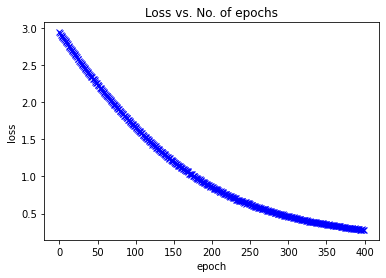

In [256]:
plot_losses(log)

In [257]:
def predict(model,img,classes,device,to_device):
    x = to_device(img.unsqueeze(0),device)
    output = model(x)
    _,pred = torch.max(output,dim=1)
    return classes[pred[0].item()]

In [258]:
@torch.no_grad()
def evaluate(model,val_loader,output=False):
    model.eval()
    outputsBatch = []
    outputArray = {
      'predicted': [],
      'labels': [],
    }
    for batch in val_loader:
      images,labels= batch
      outputs=model(images)
      loss = F.cross_entropy(outputs, labels)
      _, predicted = torch.max(outputs, dim=1)
      correct = torch.tensor(torch.sum(predicted == labels).item() / len(predicted))
      outputsBatch.append({"error": loss.detach(),"acc": correct })
      if(output):
        outputArray['predicted'].extend(predicted.detach().cpu().numpy())
        outputArray['labels'].extend(labels.detach().cpu().data.numpy())
    if(output):
        resOuput = batch_results(outputsBatch)
        resOuput['outputs'] = outputArray
        return resOuput

In [259]:
test_dataset = datasets.ImageFolder('data/test', transform=train_transforms)
# Crear el iterador para recorrer los datos de prueba en lotes
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
TEST_DATA_DL = DeviceDataLoader(test_loader, device)

In [260]:
resultsTest = evaluate(model, TEST_DATA_DL, True)
print("Error:",resultsTest['error'], "Accuracy:",resultsTest['acc'])

Error: 1.7458434104919434 Accuracy: 0.6333333253860474


In [261]:
curretTimeStap = time.strftime("%Y%m%d-%H%M%S")
acurracy_round = str(round(100*resultsTest['acc'], 2))
DIR_MODEL = 'models/objectDetentation' + curretTimeStap + '['+acurracy_round+']' +'.pth'
torch.save(model.state_dict(), DIR_MODEL)

/tmp/ipykernel_144611/2301126820.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.title("Confusion Matrix"), plt.tight_layout()


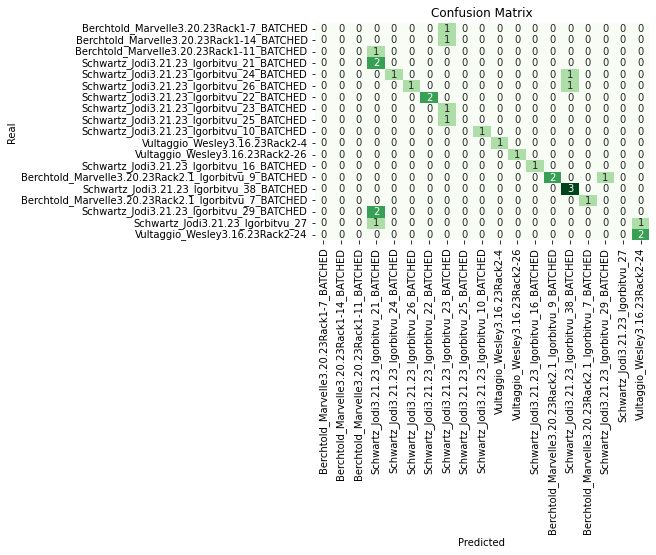

Sensitivity
63.33
Specificity
97.96
F1-score
63.33
Accuracy
63.33


In [262]:
MatrixScore(resultsTest['outputs']['labels'],resultsTest['outputs']['predicted'],CLASES)

In [226]:
len(test_dataset)

30

In [236]:
len(test_dataset.classes)

19

In [237]:
len(train_data.classes)

19

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Schwartz_Jodi3.21.23_lgorbitvu_38_BATCHED , Predicted: Schwartz_Jodi3.21.23_lgorbitvu_38_BATCHED


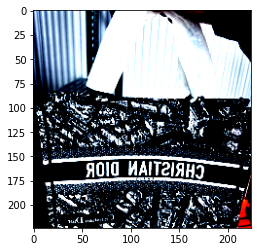

In [263]:
# test =test_dataset[0]
img1,label1= test_dataset[23]
plt.imshow(img1.permute(1, 2, 0))
print('Label:', test_dataset.classes[label1], ', Predicted:', predict(model,img1,test_dataset.classes,device,to_device))
